# DECOY: The Ultimate Measure of Offensive Misdirection


In [1]:
import plotly.graph_objects as go
import os
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from sportstransformer-utils import prep_data
import sys
import torch.nn as nn
from sklearn.preprocessing import OneHotEncoder
import torch
import numpy as np
import polars as pl
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.x
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
project_dir = '/kaggle/input/nfl-big-data-bowl-2025'

# Utility Functions

In [2]:
# You can inherit these colors from nflverse, this is for completeness/convenience 
colors = {
    'ARI':["#97233F","#000000","#FFB612"],
    'ATL':["#A71930","#000000","#A5ACAF"],
    'BAL':["#241773","#000000"],
    'BUF':["#00338D","#C60C30"],
    'CAR':["#0085CA","#101820","#BFC0BF"],
    'CHI':["#0B162A","#C83803"],
    'CIN':["#FB4F14","#000000"],
    'CLE':["#311D00","#FF3C00"],
    'DAL':["#003594","#041E42","#869397"],
    'DEN':["#FB4F14","#002244"],
    'DET':["#0076B6","#B0B7BC","#000000"],
    'GB' :["#203731","#FFB612"],
    'HOU':["#03202F","#A71930"],
    'IND':["#002C5F","#A2AAAD"],
    'JAX':["#101820","#D7A22A","#9F792C"],
    'KC' :["#E31837","#FFB81C"],
    'LA' :["#003594","#FFA300","#FF8200"],
    'LAC':["#0080C6","#FFC20E","#FFFFFF"],
    'LV' :["#000000","#A5ACAF"],
    'MIA':["#008E97","#FC4C02","#005778"],
    'MIN':["#4F2683","#FFC62F"],
    'NE' :["#002244","#C60C30","#B0B7BC"],
    'NO' :["#101820","#D3BC8D"],
    'NYG':["#0B2265","#A71930","#A5ACAF"],
    'NYJ':["#125740","#000000","#FFFFFF"],
    'PHI':["#004C54","#A5ACAF","#ACC0C6"],
    'PIT':["#FFB612","#101820"],
    'SEA':["#002244","#69BE28","#A5ACAF"],
    'SF' :["#AA0000","#B3995D"],
    'TB' :["#D50A0A","#FF7900","#0A0A08"],
    'TEN':["#0C2340","#4B92DB","#C8102E"],
    'WAS':["#5A1414","#FFB612"],
    'football':["#CBB67C","#663831"]
}

def preprocess_data(tracking_data, players_data):
    """
    merges data for the `animate_play()` function 
    """
    tracking_df = pd.merge(df,players,how="left",on = ["nflId",'displayName'])
    return tracking_df

def hex_to_rgb_array(hex_color):
    """
    take in hex val and return rgb np array
    helper for 'color distance' issues 
    """
    return np.array(tuple(int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)))

def ColorDistance(hex1,hex2):
    """
    d = {} distance between two colors(3)
    helper for 'color distance' issues 
    """
    if hex1 == hex2:
        return 0
    rgb1 = hex_to_rgb_array(hex1)
    rgb2 = hex_to_rgb_array(hex2)
    rm = 0.5*(rgb1[0]+rgb2[0])
    d = abs(sum((2+rm,4,3-rm)*(rgb1-rgb2)**2))**0.5
    return d

def ColorPairs(team1,team2):
    """
    Pairs colors given two teams
    If colors are 'too close' in hue, switch to alt color  
    """
    color_array_1 = colors[team1]
    color_array_2 = colors[team2]
    # If color distance is small enough then flip color order
    if ColorDistance(color_array_1[0],color_array_2[0])<500:
        return {
          team1:[color_array_1[0],color_array_1[1]],
          team2:[color_array_2[1],color_array_2[0]],
          'football':colors['football']
        }
    else:
        return {
          team1:[color_array_1[0],color_array_1[1]],
          team2:[color_array_2[0],color_array_2[1]],
          'football':colors['football']
        }

def animate_play(games,tracking_df,play_df,players,gameId,playId):
    """
    Generates an animated play using the tracking data. 
    """
    selected_game_df = games.filter(pl.col('gameId')==gameId)
    selected_play_df = play_df.filter((pl.col('playId')==playId) & (pl.col('gameId')==gameId))

    tracking_players_df = tracking_df
    selected_tracking_df = tracking_players_df.filter((pl.col('playId')==playId) & (pl.col('gameId')==gameId))

    sorted_frame_list = selected_tracking_df.unique(pl.col('frameId')).get_column('frameId')
    sorted_frame_list = sorted_frame_list.sort()

    # get good color combos
    team_combos = list(set(selected_tracking_df['club'].unique())-set(['football']))
    color_orders = ColorPairs(team_combos[0],team_combos[1])
    print(team_combos)
    # get play General information
    line_of_scrimmage = selected_play_df.get_column('absoluteYardlineNumber')[0]

    # Fixing first down marker issue from last year
    if selected_tracking_df.get_column('playDirection')[0] == 'left':
        line_of_scrimmage = 120 - selected_play_df.get_column('absoluteYardlineNumber')[0]
    first_down_marker = line_of_scrimmage + selected_play_df.get_column('yardsToGo')[0]
#     else:
#         first_down_marker = line_of_scrimmage - selected_play_df.get_column('yardsToGo')[0]
    down = selected_play_df.get_column('down')[0]
    quarter = selected_play_df.get_column('quarter')[0]
    gameClock = selected_play_df.get_column('gameClock')[0]
    playDescription = selected_play_df.get_column('playDescription')[0]

    # Handle case where we have a really long Play Description and want to split it into two lines
    if len(playDescription.split(" "))>15 and len(playDescription)>115:
        playDescription = " ".join(playDescription.split(" ")[0:16]) + "<br>" + " ".join(playDescription.split(" ")[16:])

    # initialize plotly start and stop buttons for animation
    updatemenus_dict = [
      {
          "buttons": [
              {
                  "args": [None, {"frame": {"duration": 100, "redraw": False},
                              "fromcurrent": True, "transition": {"duration": 0}}],
                  "label": "Play",
                  "method": "animate"
              },
              {
                  "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                    "mode": "immediate",
                                    "transition": {"duration": 0}}],
                  "label": "Pause",
                  "method": "animate"
              }
          ],
          "direction": "left",
          "pad": {"r": 10, "t": 87},
          "showactive": False,
          "type": "buttons",
          "x": 0.1,
          "xanchor": "right",
          "y": 0,
          "yanchor": "top"
      }
    ]
    # initialize plotly slider to show frame position in animation
    sliders_dict = {
      "active": 0,
      "yanchor": "top",
      "xanchor": "left",
      "currentvalue": {
          "font": {"size": 20},
          "prefix": "Frame:",
          "visible": True,
          "xanchor": "right"
      },
      "transition": {"duration": 300, "easing": "cubic-in-out"},
      "pad": {"b": 10, "t": 50},
      "len": 0.9,
      "x": 0.1,
      "y": 0,
      "steps": []
    }


    frames = []
    for frameId in sorted_frame_list:
        data = []
        # Add Numbers to Field
        data.append(
          go.Scatter(
              x=np.arange(20,110,10),
              y=[5]*len(np.arange(20,110,10)),
              mode='text',
              text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
              textfont_size = 30,
              textfont_family = "Courier New, monospace",
              textfont_color = "#ffffff",
              showlegend=False,
              hoverinfo='none'
          )
        )
        data.append(
          go.Scatter(
              x=np.arange(20,110,10),
              y=[53.5-5]*len(np.arange(20,110,10)),
              mode='text',
              text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
              textfont_size = 30,
              textfont_family = "Courier New, monospace",
              textfont_color = "#ffffff",
              showlegend=False,
              hoverinfo='none'
          )
        )
        # Add line of scrimage
        data.append(
          go.Scatter(
              x=[line_of_scrimmage,line_of_scrimmage],
              y=[0,53.5],
              line_dash='dash',
              line_color='blue',
              showlegend=False,
              hoverinfo='none'
          )
        )
        # Add First down line
        data.append(
          go.Scatter(
              x=[first_down_marker,first_down_marker],
              y=[0,53.5],
              line_dash='dash',
              line_color='yellow',
              showlegend=False,
              hoverinfo='none'
          )
        )
        # Add Endzone Colors
        endzoneColors = {0:color_orders[selected_game_df.get_column('homeTeamAbbr')[0]][0],
                        110:color_orders[selected_game_df.get_column('visitorTeamAbbr')[0]][0]}
        for x_min in [0,110]:
            data.append(
              go.Scatter(
                  x=[x_min,x_min,x_min+10,x_min+10,x_min],
                  y=[0,53.5,53.5,0,0],
                  fill="toself",
                  fillcolor=endzoneColors[x_min],
                  mode="lines",
                  line=dict(
                      color="white",
                      width=3
                      ),
                  opacity=1,
                  showlegend= False,
                  hoverinfo ="skip"
              )
            )
        # Plot Players
        for team in selected_tracking_df.get_column('club').unique():
            plot_df = selected_tracking_df.filter((pl.col('club')==team) & (pl.col('frameId')==frameId))

            if team != 'football':
                hover_text_array=[]
                jersey_numbers = []
                for nflId in plot_df['nflId'].unique():
                    selected_player_df = plot_df.filter(pl.col('nflId')==nflId)
                    nflId = int(selected_player_df.get_column('nflId')[0])
                    displayName = selected_player_df.get_column('displayName')[0]
                    jerseyNumber = int(selected_player_df.get_column('jerseyNumber')[0])
                    jersey_numbers.append(jerseyNumber)
                    s = round(selected_player_df.get_column('s')[0] * 2.23693629205, 3)
                    text_to_append = f"nflId:{nflId}<br>displayName:{displayName}<br>Player Speed:{s} MPH"
                    hover_text_array.append(text_to_append)

                data.append(go.Scatter(x=plot_df.get_column('x'), y=plot_df.get_column('y'),
                                      mode = 'markers+text',
                                       text = jersey_numbers,
                                       textfont_color="white",
                                       textposition='middle center',
                                      marker=go.scatter.Marker(color=color_orders[team][0],
                                                              line=go.scatter.marker.Line(width=2,
                                                                                          color=color_orders[team][1]),
                                                              size=20),
                                      name=team,hovertext=hover_text_array,hoverinfo='text'))
            else:
                data.append(go.Scatter(x=plot_df.get_column('x'), y=plot_df.get_column('y'),
                                      mode = 'markers',
                                      marker=go.scatter.Marker(
                                        color=color_orders[team][0],
                                        line=go.scatter.marker.Line(width=2,
                                                                    color=color_orders[team][1]),
                                        size=10),
                                      name=team,hoverinfo='none'))
        # add frame to slider
        slider_step = {'args': [
          [frameId],
          {'frame': {'duration': 100, 'redraw': False},
            'mode': 'immediate',
            'transition': {'duration': 0}}
        ],
          'label': str(frameId),
          'method': 'animate'}
        sliders_dict['steps'].append(slider_step)
        frames.append(go.Frame(data=data, name=str(frameId)))

    scale=10
    layout = go.Layout(
        autosize=False,
        width=120*scale,
        height=60*scale,
        xaxis=dict(range=[0, 120], autorange=False, tickmode='array',tickvals=np.arange(10, 111, 5).tolist(),showticklabels=False),
        yaxis=dict(range=[0, 53.3], autorange=False,showgrid=False,showticklabels=False),

        plot_bgcolor='#00B140',
        # Create title and add play description at the bottom of the chart for better visual appeal
        title=f"GameId: {gameId}, PlayId: {playId}<br>{gameClock} {quarter}Q"+"<br>"*19+f"{playDescription}",
        updatemenus=updatemenus_dict,
        sliders = [sliders_dict]
    )

    fig = go.Figure(
        data=frames[0]['data'],
        layout= layout,
        frames=frames[1:]
    )
    # Create First Down Markers
    for y_val in [0,53]:
        fig.add_annotation(
              x=first_down_marker,
              y=y_val,
              text=str(down),
              showarrow=False,
              font=dict(
                  family="Courier New, monospace",
                  size=16,
                  color="black"
                  ),
              align="center",
              bordercolor="black",
              borderwidth=2,
              borderpad=4,
              bgcolor="#ff7f0e",
              opacity=1
              )
    # Add Team Abbreviations in EndZone's
    for x_min in [0,110]:
        if x_min == 0:
            angle = 270
            teamName=selected_game_df.get_column('homeTeamAbbr')[0]
        else:
            angle = 90
            teamName=selected_game_df.get_column('visitorTeamAbbr')[0]
        fig.add_annotation(
          x=x_min+5,
          y=53.5/2,
          text=teamName,
          showarrow=False,
          font=dict(
              family="Courier New, monospace",
              size=32,
              color="White"
              ),
          textangle = angle
        )
    return fig

In [3]:
def get_game_df() -> pl.DataFrame:
    """
    Load game-level data and preprocesses features.

    Returns:
        pl.DataFrame: Preprocessed game data with additional features.
    """
    return (
        pl.read_csv(f'{project_dir}/games.csv', null_values=["NA", "nan", "N/A", "NaN", ""])
    )

def get_player_plays_df() -> pl.DataFrame:
    """
    Load player-level play data and preprocesses features.

    Returns:
        pl.DataFrame: Preprocessed player data with additional features.
    """
    return (
        pl.read_csv(f'{project_dir}/player_play.csv', null_values=["NA", "nan", "N/A", "NaN", ""])
    )
    

def get_plays_df() -> pl.DataFrame:
    """
    Load play-level data and preprocesses features.

    Returns:
        pl.DataFrame: Preprocessed play data with additional features.
    """
    return pl.read_csv(f'{project_dir}/plays.csv', null_values=["NA", "nan", "N/A", "NaN", ""]).with_columns(
        distanceToGoal=(
            pl.when(pl.col("possessionTeam") == pl.col("yardlineSide"))
            .then(100 - pl.col("yardlineNumber"))
            .otherwise(pl.col("yardlineNumber"))
        )
    )

def get_tracking_df() -> pl.DataFrame:
    """
    Load tracking data and preprocesses features. Notably, exclude rows representing the football's movement.

    Returns:
        pl.DataFrame: Preprocessed tracking data with additional features.
    """
    # don't include football rows for this project.  
    # NOTE: Only processing week 1 for the sake of time.  Change "1" to "*" to process all weeks
    return pl.read_csv(f'{project_dir}/tracking_week_*.csv', null_values=["NA", "nan", "N/A", "NaN", ""])

def get_pre_snap_tracking_df() -> pl.DataFrame:
    """
    Load tracking data and preprocesses features. Notably, exclude rows representing the football's movement.

    Returns:
        pl.DataFrame: Preprocessed tracking data with additional features.
    """
    # don't include football rows for this project.  
    # NOTE: Only processing week 1 for the sake of time.  Change "1" to "*" to process all weeks
    
    return pl.read_csv(f'{project_dir}/tracking_week_*.csv', null_values=["NA", "nan", "N/A", "NaN", ""]).filter(pl.col("frameType") == "BEFORE_SNAP")



def add_features_to_tracking_df(
    tracking_df: pl.DataFrame,
    players_df: pl.DataFrame,
    plays_df: pl.DataFrame,
) -> pl.DataFrame:
    """
    Consolidates play and player level data into the tracking data.

    Args:
        tracking_df (pl.DataFrame): Tracking data
        players_df (pl.DataFrame): Player data
        plays_df (pl.DataFrame): Play data

    Returns:
        pl.DataFrame: Tracking data with additional features.
    """
    # add `is_ball_carrier`, `team_indicator`, and other features to tracking data
    og_len = len(tracking_df)
    tracking_df = (
        tracking_df.join(
            plays_df.select(
                "gameId",
                "playId",
                "possessionTeam",
                "down",
                "yardsToGo",
            ),
            on=["gameId", "playId"],
            how="inner",
        )
        #.join(
        #    players_df.select(["nflId", "weight_Z", "height_Z"]).unique(),
        #    on="nflId",
        #    how="inner",
        #)
        .with_columns(
            side=pl.when(pl.col("club") == pl.col("possessionTeam"))
            .then(pl.lit(1))
            .otherwise(pl.lit(-1))
            .alias("side"),
        )
        .drop(["possessionTeam"])
    )
    assert len(tracking_df) == og_len, "Lost rows when joining tracking data with play/player data"

    return tracking_df


def convert_tracking_to_cartesian(tracking_df: pl.DataFrame) -> pl.DataFrame:
    """
    Convert polar coordinates to Unit-circle Cartesian format.

    Args:
        tracking_df (pl.DataFrame): Tracking data

    Returns:
        pl.DataFrame: Tracking data with Cartesian coordinates.
    """
    return (
        tracking_df.with_columns(
            dir=((pl.col("dir") - 90) * -1) % 360,
            o=((pl.col("o") - 90) * -1) % 360,
        )
        # convert polar vectors to cartesian ((s, dir) -> (vx, vy), (o) -> (ox, oy))
        .with_columns(
            vx=pl.col("s") * pl.col("dir").radians().cos(),
            vy=pl.col("s") * pl.col("dir").radians().sin(),
            ax=pl.col("a") * pl.col("dir").radians().cos(),
            ay=pl.col("a") * pl.col("dir").radians().sin(),
            ox=pl.col("o").radians().cos(),
            oy=pl.col("o").radians().sin(),
        )
    )


def standardize_tracking_directions(tracking_df: pl.DataFrame) -> pl.DataFrame:
    """
    Standardize play directions to always moving left to right.

    Args:
        tracking_df (pl.DataFrame): Tracking data

    Returns:
        pl.DataFrame: Tracking data with standardized directions.
    """
    return tracking_df.with_columns(
        x=pl.when(pl.col("playDirection") == "right").then(pl.col("x")).otherwise(120 - pl.col("x")),
        y=pl.when(pl.col("playDirection") == "right").then(pl.col("y")).otherwise(53.3 - pl.col("y")),
        vx=pl.when(pl.col("playDirection") == "right").then(pl.col("vx")).otherwise(-1 * pl.col("vx")),
        vy=pl.when(pl.col("playDirection") == "right").then(pl.col("vy")).otherwise(-1 * pl.col("vy")),
        ax=pl.when(pl.col("playDirection") == "right").then(pl.col("ax")).otherwise(-1 * pl.col("ax")),
        ay=pl.when(pl.col("playDirection") == "right").then(pl.col("ay")).otherwise(-1 * pl.col("ay")),      
        ox=pl.when(pl.col("playDirection") == "right").then(pl.col("ox")).otherwise(-1 * pl.col("ox")),
        oy=pl.when(pl.col("playDirection") == "right").then(pl.col("oy")).otherwise(-1 * pl.col("oy")),
    )

def get_players_df() -> pl.DataFrame:
    """
    Load player-level data and preprocesses features.

    Returns:
        pl.DataFrame: Preprocessed player data with additional features.
    """
    return (
        pl.read_csv(f'{project_dir}/players.csv', null_values=["NA", "nan", "N/A", "NaN", ""])
        .with_columns(
            height_inches=(
                pl.col("height").str.split("-").map_elements(lambda s: int(s[0]) * 12 + int(s[1]), return_dtype=int)
            )
        )
    )

In [4]:
plays = get_plays_df()
players = get_players_df()
# tracking_df = get_tracking_df()
pre_snap_tracking_df = get_pre_snap_tracking_df()
games = get_game_df()
player_play = get_player_plays_df()

In [5]:
tracking_df = get_tracking_df()
tracking_df_cartesian = convert_tracking_to_cartesian(tracking_df)
tracking_df_standardized = standardize_tracking_directions(tracking_df_cartesian)

In [6]:
pre_snap_tracking_df_cartesian = convert_tracking_to_cartesian(pre_snap_tracking_df)
pre_snap_tracking_df_standardized = standardize_tracking_directions(pre_snap_tracking_df_cartesian)

# Aggregating Player Tracking Data

In [ ]:
player_data =[]
all_play_dfs = []
i = 0
#Go Through Each Game in NFL Season
for game in pre_snap_tracking_df_standardized.get_column('gameId').unique():
    
    #Get Current Game
    current_game_df = games.filter((pl.col('gameId')==game))
    
    #Teams in Current Game
    home_team = current_game_df.get_column('homeTeamAbbr')[0]
    away_team = current_game_df.get_column('visitorTeamAbbr')[0]
    
    #Go Through all Plays in Game
    for play in pre_snap_tracking_df_standardized.filter(pl.col('gameId')==game).get_column('playId').unique():

        
        print(i)
        i += 1
        #Get the Player Tracking for Current Play
        selected_play_tracking_df = pre_snap_tracking_df_standardized.filter((pl.col('gameId')==game) & (pl.col('playId')==play))
        
        #Get Play Info about Current Play
        current_play_df = plays.filter((pl.col('gameId')==game) & (pl.col('playId')==play))
        
        #Get Player Info About Current Play
        current_player_play_df = player_play.filter((pl.col('gameId')==game) & (pl.col('playId')==play))
        
        #Team in Possession
        possession_team = current_play_df.get_column('possessionTeam')[0]
        
        
        #Filter for Only Players on Offense
        current_player_play_df = current_player_play_df.filter(pl.col('teamAbbr') == possession_team)
        
        #Get Only Last 10 frames before ball snapped
        line_set_idx = selected_play_tracking_df.select('frameId').max()[0] - 10
        
        # line_set_idx = selected_play_tracking_df.filter(pl.col("event") == "line_set").select(pl.col("frameId"))[0] - 10
        if line_set_idx.shape[0] == 0:
            continue
            
        #Get only data of last 10 frames
        data_after_line_set = selected_play_tracking_df.filter((pl.col('frameId') >= line_set_idx))
        data_after_line_set = data_after_line_set.with_columns(pl.when(pl.col('club') == possession_team).then(True).otherwise(False).alias('onOffense'))
        data_after_line_set = data_after_line_set.with_columns(pl.when(pl.col('displayName')=='football').then(True).otherwise(pl.col('onOffense')).alias('onOffense'))
        data_after_line_set = data_after_line_set.filter(pl.col('onOffense') == True)
        
        
        #Aggregate Summary Stats for Player Pre-Snap Movement Specifically Mean, Std, Max, Min across all frames before snap for Position, Velocity, and Orientation
        data_after_line_set = data_after_line_set.with_columns(pl.when(pl.col('displayName')=='football').then(0).otherwise(pl.col('nflId')).alias("nflId"))
        football_position = data_after_line_set.filter((pl.col('displayName') == "football"))[0].select(['x', 'y'])
        # print(football_position)
        data_after_line_set = data_after_line_set.with_columns((pl.col("x")- football_position.select('x')).alias("x"))
        data_after_line_set = data_after_line_set.with_columns((pl.col("y")- football_position.select('y')).alias("y"))
        result = data_after_line_set.group_by("nflId").agg([pl.col("x").mean().alias("x_mean"), pl.col("y").mean().alias("y_mean"), pl.col("vx").mean().alias("vx_mean"), pl.col("vy").mean().alias("vy_mean"), pl.col("ox").mean().alias("ox_mean"), pl.col("oy").mean().alias("oy_mean"), pl.col("x").std().alias("x_std"), pl.col("y").std().alias("y_std"), pl.col("vx").std().alias("vx_std"), pl.col("vy").std().alias("vy_std"), pl.col("ox").std().alias("ox_std"), pl.col("oy").std().alias("oy_std"), pl.col("x").max().alias("x_max"), pl.col("y").max().alias("y_max"), pl.col("vx").max().alias("vx_max"), pl.col("vy").max().alias("vy_max"), pl.col("ox").max().alias("ox_max"), pl.col("oy").max().alias("oy_max"), pl.col("x").min().alias("x_min"), pl.col("y").min().alias("y_min"), pl.col("vx").min().alias("vx_min"), pl.col("vy").min().alias("vy_min"), pl.col("ox").min().alias("ox_min"), pl.col("oy").min().alias("oy_min")])
        result = result.filter((pl.col('nflId') != 0))
        
        
#         result = result.with_columns(pl.when(pl.col('nflId')==0).then(0).otherwise(pl.col('vx_mean')).alias("vx_mean"))
#         result = result.with_columns(pl.when(pl.col('nflId')==0).then(0).otherwise(pl.col('vy_mean')).alias("vy_mean"))
#         result = result.with_columns(pl.when(pl.col('nflId')==0).then(0).otherwise(pl.col('ox_mean')).alias("ox_mean"))
#         result = result.with_columns(pl.when(pl.col('nflId')==0).then(0).otherwise(pl.col('oy_mean')).alias("oy_mean"))
#         result = result.drop(['x_mean', 'y_mean'])
        
        
        #Incorporate Other Pre-Snap Information for each player
        player_pre_snap_attributes = current_player_play_df.select(['playId', 'gameId', 'nflId', 'inMotionAtBallSnap', 'shiftSinceLineset', 'motionSinceLineset'])
        result = result.join(player_pre_snap_attributes, on='nflId', how='outer')
        
        result = result.drop('nflId_right')
        result = result.join(players, on='nflId', how='left')
        result = result.with_columns(pl.when(pl.col('nflId')==0).then(0).otherwise(pl.col('inMotionAtBallSnap').cast(pl.Int8)).alias("inMotionAtBallSnap"))
        result = result.with_columns(pl.when(pl.col('nflId')==0).then(0).otherwise(pl.col('shiftSinceLineset').cast(pl.Int8)).alias("shiftSinceLineset"))
        player_node_data = result.with_columns(pl.when(pl.col('nflId')==0).then(0).otherwise(pl.col('motionSinceLineset').cast(pl.Int8)).alias("motionSinceLineset"))
        player_node_data = player_node_data.with_columns(pl.when(pl.col('nflId')==0).then(0).otherwise(pl.col('position')).alias("position"))
        player_node_data = player_node_data.with_columns(pl.when(pl.col('nflId')==0).then(0).otherwise(pl.col('weight')).alias('weight'))
        player_node_data = player_node_data.with_columns(pl.when(pl.col('nflId')==0).then(0).otherwise(pl.col('height_inches')).alias('height_inches'))
        nflNames = player_node_data.select(['displayName'])
        player_node_data_features = player_node_data.drop(['birthDate', 'height','collegeName'])
        player_node_data_features = player_node_data_features.fill_null(0)
        player_node_data_features = player_node_data_features.with_columns(pl.when(pl.col("position").is_in(["C", "T", "G"])).then(pl.lit("OL")).otherwise(pl.col("position")).alias("position"))
        player_node_data_features = player_node_data_features.with_columns(pl.when(pl.col("position").is_in(["FB"])).then(pl.lit("RB")).otherwise(pl.col("position")).alias("position"))

        player_data.append(player_node_data_features)
        aggregated_position_features = player_node_data_features.group_by("position").agg([pl.col("x_mean").mean().alias("x_mean"), pl.col("y_mean").mean().alias("y_mean"), pl.col("vx_mean").mean().alias("vx_mean"),pl.count().alias("count"), pl.col("vy_mean").mean().alias("vy_mean"), pl.col("ox_mean").mean().alias("ox_mean"), pl.col("oy_mean").mean().alias("oy_mean"), pl.col("x_mean").std().alias("x_std"), pl.col("y_mean").std().alias("y_std"), pl.col("vx_mean").std().alias("vx_std"), pl.col("vy_mean").std().alias("vy_std"), pl.col("ox_mean").std().alias("ox_std"), pl.col("oy_mean").std().alias("oy_std"), pl.col("x_max").max().alias("x_max"), pl.col("y_max").max().alias("y_max"), pl.col("vx_max").max().alias("vx_max"), pl.col("vy_max").max().alias("vy_max"), pl.col("ox_max").max().alias("ox_max"), pl.col("oy_max").max().alias("oy_max"), pl.col("x_min").min().alias("x_min"), pl.col("y_min").min().alias("y_min"), pl.col("vx_min").min().alias("vx_min"), pl.col("vy_min").min().alias("vy_min"), pl.col("ox_min").min().alias("ox_min"), pl.col("oy_min").min().alias("oy_min")])
        
        aggregated_position_features = aggregated_position_features.fill_null(0)
                                                                        
        if len(aggregated_position_features.select("position").unique()) != 5:
            continue

        all_pos_features = []
        for position in ["QB","OL", "RB", "WR", "TE"]:
            pos_features = aggregated_position_features.filter(pl.col("position") == position)
            prefix = f'{position}_'
            pos_features = pos_features.drop('position')
            pos_features = pos_features.rename({col: f"{prefix}{col}" for col in pos_features.columns})
            all_pos_features.append(pos_features)
        all_pos_features = pl.concat(all_pos_features, how="horizontal")


        
        #Incorporate Play Contextual Information (Down/Distance/Quarter/YardsToGo/etc.)
        play_contextual_data = current_play_df.select(['gameId', 'playId', 'quarter', 'down', 'yardsToGo', 'distanceToGoal', 'receiverAlignment', 'offenseFormation', 'gameClock', 	'possessionTeam', 'defensiveTeam', 'preSnapHomeScore', 'preSnapVisitorScore', 'isDropback'])
        play_contextual_data = play_contextual_data.with_columns(
            (
        pl.col("gameClock").str.strptime(pl.Time, format="%H:%M")).alias("timeRemaining")
            )
        play_contextual_data = play_contextual_data.with_columns(
            (
        pl.col("timeRemaining").dt.hour().cast(pl.Int32) * 60 + pl.col("timeRemaining").dt.minute().cast(pl.Int32)).alias("secondsRemaining")
            )
        
        play_contextual_data =  play_contextual_data.drop(['gameClock', 'timeRemaining'])
        
        play_contextual_data = play_contextual_data.with_columns(pl.when(possession_team == home_team).then(pl.col('preSnapHomeScore')).otherwise('preSnapVisitorScore').alias('pointsFor'))
        play_contextual_data = play_contextual_data.with_columns(pl.when(possession_team == home_team).then(pl.col('preSnapVisitorScore')).otherwise('preSnapHomeScore').alias('pointsAgainst'))
        play_contextual_data =  play_contextual_data.drop(['preSnapHomeScore', 'preSnapVisitorScore'])
        


        full_play_data = pl.concat([play_contextual_data, all_pos_features], how="horizontal") 
        all_play_dfs.append(full_play_data)


In [ ]:
all_play_dfs = pl.concat(all_play_dfs, how="vertical")
all_play_dfs = all_play_dfs.with_columns(all_play_dfs.select(['receiverAlignment', 'offenseFormation']).to_dummies())

all_player_features = pl.concat(player_data, how="vertical")
all_player_features.write_csv("player_play_tracking.csv")
all_play_dfs.write_csv("datasetRenamed.csv")

# Training Model

In [10]:
#Read DataFrame
all_play_dfs = pl.read_csv("datasetRenamed.csv")

# Add Week to Each Play
weeks = games.select(['week', 'gameId'])
all_play_dfs = all_play_dfs.join(weeks, on='gameId', how='left')
all_play_dfs = all_play_dfs.drop_nulls()


# Split into features and labels (drop max velocities due to noise)
X = all_play_dfs.drop(["isDropback", "gameId", "playId", "offenseFormation", "receiverAlignment", "OL_vx_max", "OL_vx_min", "WR_vx_max", "WR_vx_min", "RB_vx_max", "RB_vx_min", "QB_vx_max", "QB_vx_min", "TE_vx_max", "TE_vx_min", "RB_vy_max", "RB_vy_min", "OL_vy_max", "OL_vy_min", "QB_vy_max", "QB_vy_min", "WR_vy_max", "WR_vy_min", "TE_vy_max", "TE_vy_min", "possessionTeam", "defensiveTeam"])  # Features

#Get Weeks, Play IDs, Game IDs
week_column = X.select("week").to_numpy().squeeze()  
teams = all_play_dfs.select('possessionTeam').to_numpy()[:, 0]
gamesIds = all_play_dfs.select('gameId').to_numpy()[:, 0]
playIds = all_play_dfs.select('playId').to_numpy()[:, 0]

#Get Target Variable
y = all_play_dfs.select(["isDropback"]).to_numpy().squeeze().astype(int)  # Labels

#Drop the Week
X = X.drop('week')  

#Feature Scaling
standard_scalar = StandardScaler()
X_scaled = standard_scalar.fit_transform(X.to_numpy()) 
    

# Use the `week` column as a mask to split `y`
#Test Set = Week 9
condition = (week_column == 9)

test_teams = teams
test_games = gamesIds
test_plays = playIds
    
# Train-Test Split Based on Weeks
X_train, X_test, y_train, y_test = X_scaled[~condition], X_scaled[condition], y[~condition], y[condition]
print(y_train)
#Initialize XGBoost Model
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
# model = XGBClassifier(n_estimators=100, scale_pos_weight=scale_pos_weight)
model = XGBClassifier(scale_pos_weight=scale_pos_weight, reg_lambda=300)
        
        
# Train the Model
model.fit(X_train, y_train)

# Get feature importance scores
importance = model.feature_importances_
        

        
# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance
}).sort_values(by='Importance', ascending=False)
        
# Predict on Test Data
y_pred = model.predict(X_test)
        
# Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=False)
        
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report %s:")
print(report)

[1 1 0 ... 0 0 0]
Accuracy: 0.82

Confusion Matrix:
[[513  88]
 [187 713]]

Classification Report %s:
              precision    recall  f1-score   support

           0       0.73      0.85      0.79       601
           1       0.89      0.79      0.84       900

    accuracy                           0.82      1501
   macro avg       0.81      0.82      0.81      1501
weighted avg       0.83      0.82      0.82      1501



In [9]:
#K-Fold Validation
from sklearn.model_selection import KFold, cross_val_score
kf = KFold(n_splits=10, shuffle=True, random_state=41)
score_list = cross_val_score(model, X_scaled, y, cv=kf, scoring='accuracy')

print("10-Fold Cross Validation Scores: ", score_list)
print("Average 10-Fold Cross Validation Accuracy: ", np.mean(score_list))

10-Fold Cross Validation Scores:  [0.80692752 0.81975625 0.80243746 0.81719051 0.80564464 0.82296344
 0.83130212 0.81771502 0.81578947 0.79011553]
Average 10-Fold Cross Validation Accuracy:  0.8129841962813134


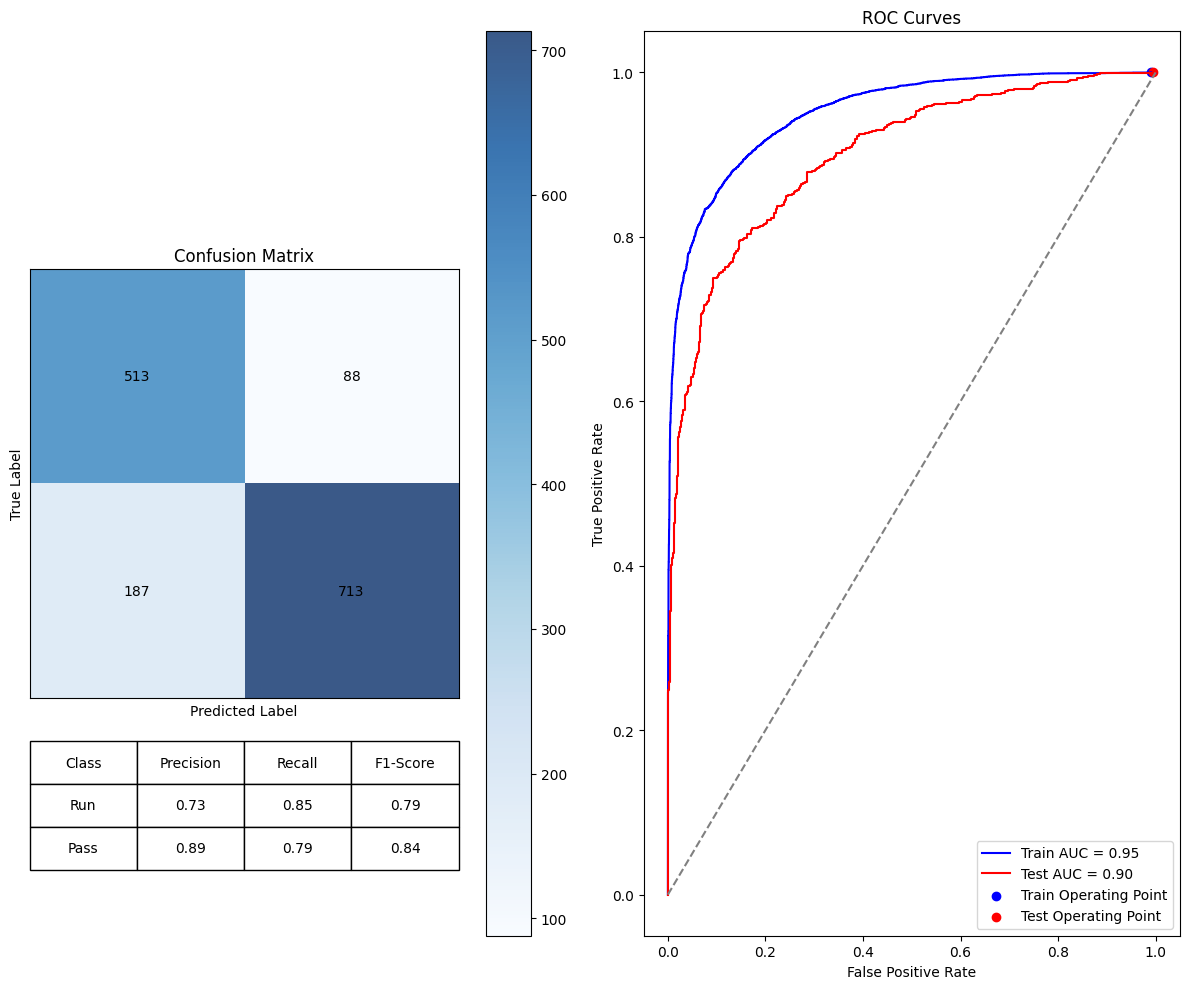

In [11]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay
# Compute ROC curve and AUC for training and test sets
y_train_pred = model.predict_proba(X_train)[:, 1]
y_test_pred = model.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)


# Extract relevant metrics for the table
metrics_table = [
    ["Class", "Precision", "Recall", "F1-Score"],
    ["Run", f"{report['0']['precision']:.2f}", f"{report['0']['recall']:.2f}", f"{report['0']['f1-score']:.2f}"],
    ["Pass", f"{report['1']['precision']:.2f}", f"{report['1']['recall']:.2f}", f"{report['1']['f1-score']:.2f}"]
]

# Visualize Confusion Matrix and AUC
fig, ax = plt.subplots(1, 2, figsize=(12, 10))

# Plot confusion matrix
cax = ax[0].matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.8)
fig.colorbar(cax, ax=ax[0])
for (i, j), val in np.ndenumerate(conf_matrix):
    ax[0].text(j, i, f"{val}", ha='center', va='center')
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Predicted Label")
ax[0].set_ylabel("True Label")

# Add the table below the confusion matrix
ax[0].table(cellText=metrics_table, loc="bottom", cellLoc="center", bbox=[0, -0.4, 1, 0.3])
ax[0].set_xticks([])
ax[0].set_yticks([])


# Plot ROC Curves
ax[1].plot(fpr_train, tpr_train, label=f"Train AUC = {auc_train:.2f}", color='blue')
ax[1].plot(fpr_test, tpr_test, label=f"Test AUC = {auc_test:.2f}", color='red')
ax[1].scatter([fpr_train[np.argmax(tpr_train)]], [tpr_train[np.argmax(tpr_train)]], color='blue', label="Train Operating Point")
ax[1].scatter([fpr_test[np.argmax(tpr_test)]], [tpr_test[np.argmax(tpr_test)]], color='red', label="Test Operating Point")
ax[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
ax[1].set_title("ROC Curves")
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].legend()

plt.tight_layout()
# plt.show()
plt.savefig("modelPerformance.jpg")

# Team Rankings

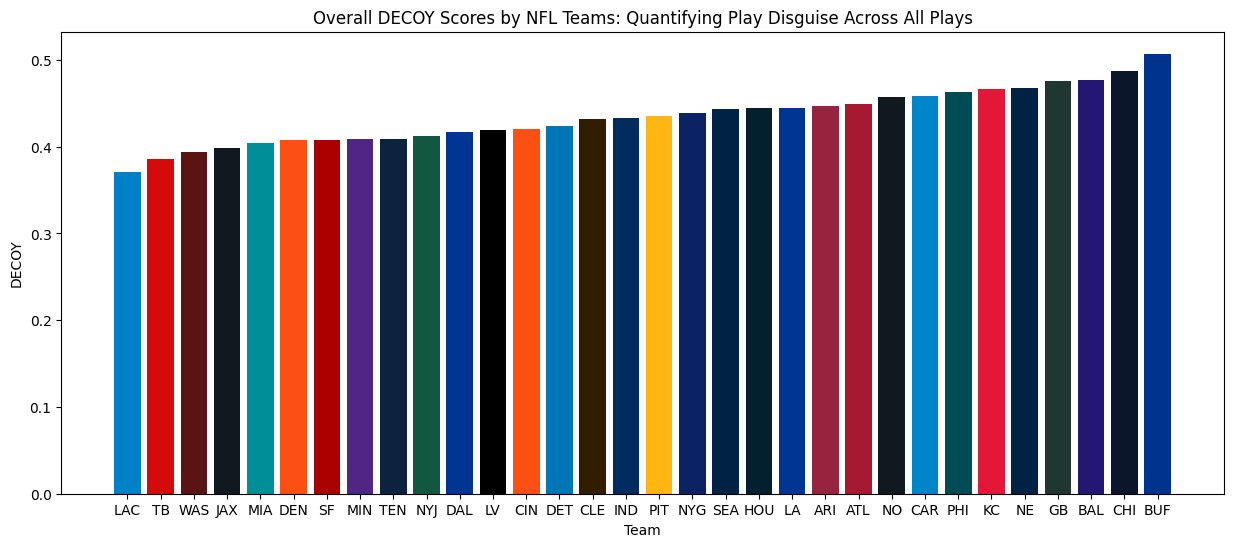

In [9]:
#Team Level DECOY Aggregated Ratings

epsilon = 1e-10
pRun, pPass = model.predict_proba(X_scaled)[:, 0], model.predict_proba(X_scaled)[:, 1]
entropy = -(pRun * np.log2(pRun + epsilon) + pPass * np.log2(pPass + epsilon))
df = pl.DataFrame({"Entropy" : entropy, "pRun" : pRun, "pPass" : pPass, "gameId" : test_games, "playId" : test_plays})
df = df.with_columns(pl.Series("Predicted", model.predict(X_scaled)))
df = df.with_columns(pl.Series("isPass", y))
df = df.with_columns((df["isPass"] != df["Predicted"]).alias("misclassified"))
df = df.with_columns((df["isPass"] == df["Predicted"]).alias("correct"))
df = df.with_columns((1.5 * pl.col('misclassified') * (1 - pl.col('Entropy')) +  0.9 * pl.col('correct') * (pl.col('Entropy'))).alias('DECOY'))
df = df.with_columns(pl.Series('possessionTeam', test_teams))


odr_team = df.group_by("possessionTeam").agg(pl.col("DECOY").mean().alias("DECOY"))
odr_team = odr_team.sort('DECOY')
        
plt.figure(figsize=(15, 6))
plt.xlabel("Team")
plt.ylabel("DECOY")
plt.title("Overall DECOY Scores by NFL Teams: Quantifying Play Disguise Across All Plays")
        #tick_label does the some work as plt.xticks()
team_colors = [colors[a][0] for a in odr_team['possessionTeam']]
plt.bar(range(len(odr_team)),odr_team['DECOY'],tick_label=odr_team['possessionTeam'], color=team_colors)
plt.savefig("decoyTeamRatings.jpg")
plt.show()

# EPA (3rd Down) vs. DECOY Co

In [12]:
weeks = games.select(['week', 'gameId'])
plays = plays.join(weeks,on="gameId",how="left")

In [13]:
pa_stats = plays.select(['isDropback','pff_passCoverage', 'passResult', 'timeToThrow', 'playAction','homeTeamWinProbabilityAdded', 'yardsGained', 'pff_manZone', 'yardsToGo', 'distanceToGoal', 'week', 'expectedPointsAdded', 'gameId', 'playId', 'prePenaltyYardsGained', 'down'])
pa_stats = pa_stats.filter((pl.col('down') == 3)).with_columns((pl.col('expectedPointsAdded')).alias('EPA/Completion')).select(['gameId', 'EPA/Completion', 'playId'])
# pa_stats = pa_stats.filter(pl.col('pff_manZone') == 'Zone').with_columns((pl.col('expectedPointsAdded') >= 1.0).alias('EPA/Completion')).select(['gameId', 'EPA/Completion'])

# pa_stats = pa_stats.with_columns((pl.col("yardsGained") >= pl.col("yardsToGo")).alias('1st Down'))
pa_df = df.join(pa_stats, on=['gameId', 'playId'], how='inner')

0.3487741593057877
Correlation coefficient: 0.35
P-value: 0.0504


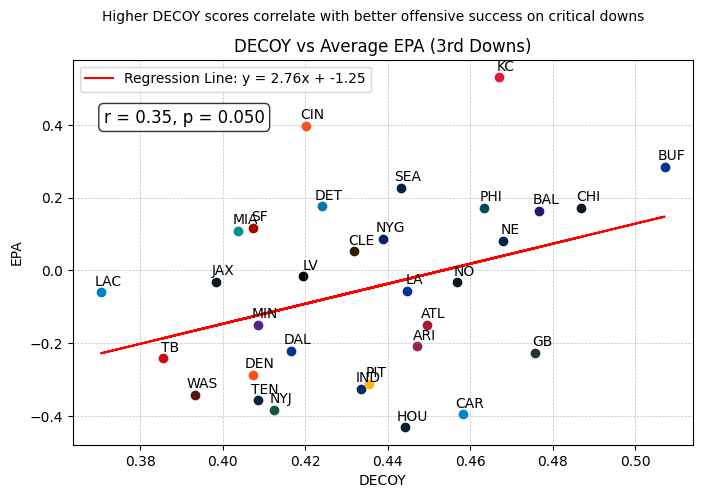

In [14]:
# pa_df = df
from scipy.stats import pearsonr
from scipy.stats import linregress

pa_df = pa_df.group_by(pl.col('possessionTeam')).agg(pl.col("EPA/Completion").mean().alias("EPA/Completion"))
pa_df = pa_df.join(odr_team, how="inner", on="possessionTeam")
pa_df = pa_df.sort('EPA/Completion')
# pa_df = pa_df.filter(pl.col('possessionTeam') != "MIA")
x = pa_df["DECOY"].to_numpy()
y = pa_df['EPA/Completion'].to_numpy()

# Calculate correlation coefficient
correlation_coef = np.corrcoef(x, y)[0, 1]
print(correlation_coef)

r, p_value = pearsonr(x, y)
slope, intercept, r_value, p_value, std_err = linregress(x, y)
regression_line = slope * x + intercept  # Regression line values

print(f"Correlation coefficient: {r:.2f}")
print(f"P-value: {p_value:.4f}")

# Create scatter plot
plt.figure(figsize=(8, 5))

for i in range(len(x)):
    plt.scatter(x[i], y[i], color=colors[pa_df["possessionTeam"][i]][0])
    plt.annotate(pa_df["possessionTeam"][i], (x[i], y[i]), textcoords="offset points", xytext=(5, 5), ha='center')
plt.plot(x, regression_line, color='red', label=f'Regression Line: y = {slope:.2f}x + {intercept:.2f}')  # Regression line
plt.title("DECOY vs Average EPA (3rd Downs)")
plt.suptitle("Higher DECOY scores correlate with better offensive success on critical downs", fontsize=10)
# Annotate correlation coefficient and p-value
plt.text(0.05, 0.85, f"r = {r_value:.2f}, p = {p_value:.3f}", 
         ha='left', va='center', transform=plt.gca().transAxes, 
         fontsize=12, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.xlabel("DECOY")
plt.ylabel("EPA")
plt.legend()
# Add subtle grid lines
plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.5, color='gray')
plt.savefig("decoyEPA.jpg")
plt.show()


# SHAP Feature Importance

In [15]:
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_scaled)

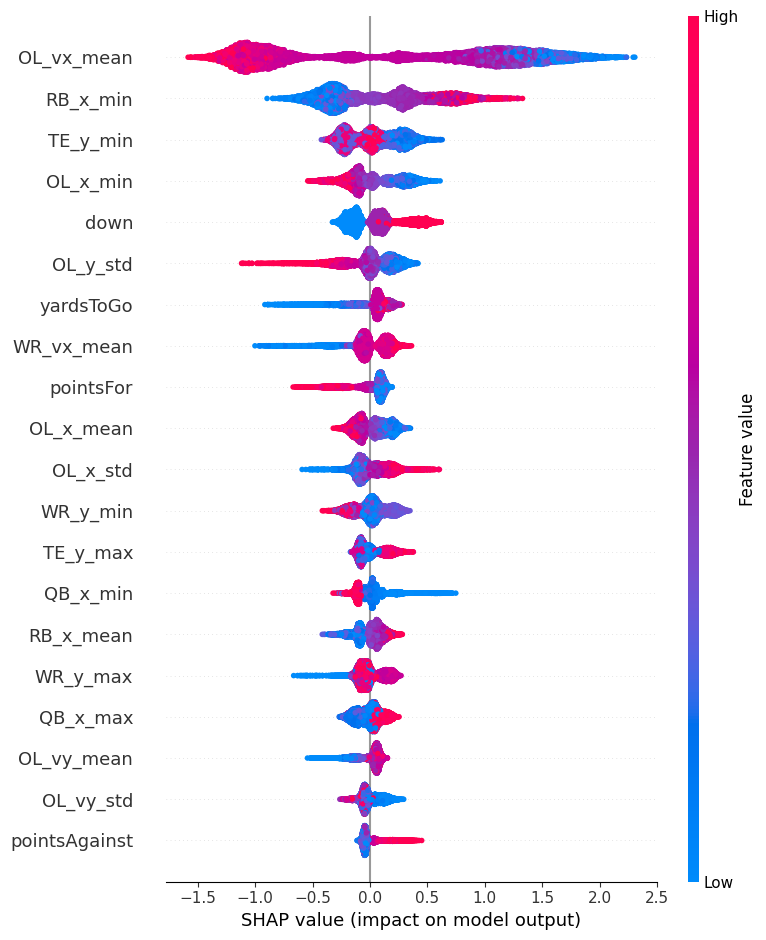

In [16]:
shap.summary_plot(shap_values, pd.DataFrame(X_scaled, columns = X.columns), show=False)
# Save the plot
plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
plt.show()  # Close the plot to avoid overlapping plots in future visualizations

# DECOY Inference Functions

In [17]:
from matplotlib.animation import FuncAnimation
import matplotlib.ticker as ticker
import shap


def run_inference_on_play(playId, gameId, frameId, windowSize=10):
    selected_play_tracking_df = pre_snap_tracking_df_standardized.filter((pl.col('gameId') == gameId) & (pl.col('playId') == playId))
    #Get Play Info about Current Play
    current_play_df = plays.filter((pl.col('gameId')==gameId) & (pl.col('playId')==playId))

    current_game_df = games.filter((pl.col('gameId') == gameId))
    #Get Player Info About Current Play
    current_player_play_df = player_play.filter((pl.col('gameId')==gameId) & (pl.col('playId')==playId))
        
    #Team in Possession
    possession_team = current_play_df.get_column('possessionTeam')[0]
    
    home_team = current_game_df.get_column('homeTeamAbbr')[0]
    away_team = current_game_df.get_column('visitorTeamAbbr')[0]

     #Filter for Only Players on Offense
    current_player_play_df = current_player_play_df.filter(pl.col('teamAbbr') == possession_team)

    startingWindow = frameId - windowSize
    data_after_line_set = selected_play_tracking_df.filter((pl.col('frameId') >= startingWindow))
    data_after_line_set = data_after_line_set.with_columns(pl.when(pl.col('club') == possession_team).then(True).otherwise(False).alias('onOffense'))
    data_after_line_set = data_after_line_set.with_columns(pl.when(pl.col('displayName')=='football').then(True).otherwise(pl.col('onOffense')).alias('onOffense'))
    data_after_line_set = data_after_line_set.filter(pl.col('onOffense') == True)
        
        
    #Aggregate Summary Stats for Player Pre-Snap Movement Specifically Mean, Std, Max, Min across all frames before snap for Position, Velocity, and Orientation
    data_after_line_set = data_after_line_set.with_columns(pl.when(pl.col('displayName')=='football').then(0).otherwise(pl.col('nflId')).alias("nflId"))
    football_position = data_after_line_set.filter((pl.col('displayName') == "football"))[0].select(['x', 'y'])
        # print(football_position)
    data_after_line_set = data_after_line_set.with_columns((pl.col("x")- football_position.select('x')).alias("x"))
    data_after_line_set = data_after_line_set.with_columns((pl.col("y")- football_position.select('y')).alias("y"))
    result = data_after_line_set.group_by("nflId").agg([pl.col("x").mean().alias("x_mean"), pl.col("y").mean().alias("y_mean"), pl.col("vx").mean().alias("vx_mean"), pl.col("vy").mean().alias("vy_mean"), pl.col("ox").mean().alias("ox_mean"), pl.col("oy").mean().alias("oy_mean"), pl.col("x").std().alias("x_std"), pl.col("y").std().alias("y_std"), pl.col("vx").std().alias("vx_std"), pl.col("vy").std().alias("vy_std"), pl.col("ox").std().alias("ox_std"), pl.col("oy").std().alias("oy_std"), pl.col("x").max().alias("x_max"), pl.col("y").max().alias("y_max"), pl.col("vx").max().alias("vx_max"), pl.col("vy").max().alias("vy_max"), pl.col("ox").max().alias("ox_max"), pl.col("oy").max().alias("oy_max"), pl.col("x").min().alias("x_min"), pl.col("y").min().alias("y_min"), pl.col("vx").min().alias("vx_min"), pl.col("vy").min().alias("vy_min"), pl.col("ox").min().alias("ox_min"), pl.col("oy").min().alias("oy_min")])
    result = result.filter((pl.col('nflId') != 0))

    result = result.join(players, on='nflId', how='left')
    player_node_data = result.with_columns(pl.when(pl.col('nflId')==0).then(0).otherwise(pl.col('position')).alias("position"))
    player_node_data = player_node_data.with_columns(pl.when(pl.col('nflId')==0).then(0).otherwise(pl.col('weight')).alias('weight'))
    player_node_data = player_node_data.with_columns(pl.when(pl.col('nflId')==0).then(0).otherwise(pl.col('height_inches')).alias('height_inches'))
    nflNames = player_node_data.select(['displayName'])
    # print(nflNames)
    player_node_data_features = player_node_data.drop(['birthDate', 'height','collegeName'])
    player_node_data_features = player_node_data_features.fill_null(0)
    player_node_data_features = player_node_data_features.with_columns(pl.when(pl.col("position").is_in(["C", "T", "G"])).then(pl.lit("OL")).otherwise(pl.col("position")).alias("position"))
    player_node_data_features = player_node_data_features.with_columns(pl.when(pl.col("position").is_in(["FB"])).then(pl.lit("RB")).otherwise(pl.col("position")).alias("position"))


    aggregated_position_features = player_node_data_features.group_by("position").agg([pl.col("x_mean").mean().alias("x_mean"), pl.col("y_mean").mean().alias("y_mean"), pl.col("vx_mean").mean().alias("vx_mean"),pl.count().alias("count"), pl.col("vy_mean").mean().alias("vy_mean"), pl.col("ox_mean").mean().alias("ox_mean"), pl.col("oy_mean").mean().alias("oy_mean"), pl.col("x_mean").std().alias("x_std"), pl.col("y_mean").std().alias("y_std"), pl.col("vx_mean").std().alias("vx_std"), pl.col("vy_mean").std().alias("vy_std"), pl.col("ox_mean").std().alias("ox_std"), pl.col("oy_mean").std().alias("oy_std"), pl.col("x_max").max().alias("x_max"), pl.col("y_max").max().alias("y_max"), pl.col("ox_max").max().alias("ox_max"), pl.col("oy_max").max().alias("oy_max"), pl.col("x_min").min().alias("x_min"), pl.col("y_min").min().alias("y_min"), pl.col("ox_min").min().alias("ox_min"), pl.col("oy_min").min().alias("oy_min")])
        
    aggregated_position_features = aggregated_position_features.fill_null(0)
                                                                        

    all_pos_features = []
    for position in ["QB","OL", "RB", "WR", "TE"]:
        pos_features = aggregated_position_features.filter(pl.col("position") == position)
        prefix = f'{position}_'
        pos_features = pos_features.drop('position')
        pos_features = pos_features.rename({col: f"{prefix}{col}" for col in pos_features.columns})
        all_pos_features.append(pos_features)
    all_pos_features = pl.concat(all_pos_features, how="horizontal")

    play_contextual_data = current_play_df.select(['gameId', 'playId', 'quarter', 'down', 'yardsToGo', 'distanceToGoal', 'receiverAlignment', 'offenseFormation', 'gameClock', 	'possessionTeam', 'defensiveTeam', 'preSnapHomeScore', 'preSnapVisitorScore', 'isDropback'])
    play_contextual_data = play_contextual_data.with_columns(
            (
        pl.col("gameClock").str.strptime(pl.Time, format="%H:%M")).alias("timeRemaining")
            )
    play_contextual_data = play_contextual_data.with_columns(
            (
        pl.col("timeRemaining").dt.hour().cast(pl.Int32) * 60 + pl.col("timeRemaining").dt.minute().cast(pl.Int32)).alias("secondsRemaining")
            )
        
    play_contextual_data =  play_contextual_data.drop(['gameClock', 'timeRemaining'])
        
    play_contextual_data = play_contextual_data.with_columns(pl.when(possession_team == home_team).then(pl.col('preSnapHomeScore')).otherwise('preSnapVisitorScore').alias('pointsFor'))
    play_contextual_data = play_contextual_data.with_columns(pl.when(possession_team == home_team).then(pl.col('preSnapVisitorScore')).otherwise('preSnapHomeScore').alias('pointsAgainst'))
    play_contextual_data =  play_contextual_data.drop(['preSnapHomeScore', 'preSnapVisitorScore'])
        


    full_play_data = pl.concat([play_contextual_data, all_pos_features], how="horizontal") 
    X = full_play_data.drop(["isDropback", "gameId", "playId", "offenseFormation", "receiverAlignment", "possessionTeam", "defensiveTeam"])  # Features
    X_transformed = standard_scalar.transform(X.to_numpy())
    # print(X_transformed)
    y = full_play_data.select('isDropback').to_numpy().squeeze()
    pred = model.predict_proba(X_transformed).squeeze()
    y_pred = model.predict(X_transformed).squeeze()
    explainer = shap.TreeExplainer(model)
    

    shap_values = np.abs(explainer.shap_values(X_transformed))
    shap_values = shap_values / np.sum(shap_values)

    shap_values_df = pl.DataFrame(shap_values, schema=X.columns)

    pRun, pPass = pred[0], pred[1]

    mispredicted = y_pred != y
    return pRun, pPass, shap_values_df, mispredicted
    
def get_decoy(pRun, pPass, misclassified, alpha=1.5, beta=0.9):
    entropy = -(pRun * np.log2(pRun) + pPass * np.log2(pPass))
    return alpha * misclassified * (1 - entropy) + beta * (1 - misclassified) * entropy



# Generating Probability Animations

In [ ]:
pRuns = []
pPasses = []
gameId = 2022101610
playId = 2876
maxFrame = pre_snap_tracking_df_standardized.filter((pl.col('gameId') == gameId) & (pl.col('playId') == playId)).select(pl.col('frameId')).max().to_numpy()[0, 0]
startingFrame = 70
for i in range(startingFrame, maxFrame + 1):
    pRun, pPass, _, _ = run_inference_on_play(playId, gameId, i)
    print(pRun, pPass)
    pRuns.append(pRun)
    pPasses.append(pPass)


# Set up the figure and axis
fig, ax = plt.subplots()
x = np.linspace(startingFrame, maxFrame + 1, maxFrame + 1 - startingFrame)
print(len(x))
runLine, = ax.plot([], [], lw=2, label="Run Probability")  # Create an empty line object
passLine, = ax.plot([], [], lw=2, label="Pass Probability")  # Create an empty line object
ax.set_xlim(startingFrame, maxFrame + 5)
ax.set_ylim(0, 1)
ax.set_xlabel("Frame")
ax.set_ylabel("Probability")
ax.set_title("Probability of Run vs. Pass")

# Initialization function (sets up the plot)
def init():
    runLine.set_data([], [])  # Start with an empty line
    passLine.set_data([], [])  # Start with an empty line
    return runLine, passLine

# Update function (called for each frame)
def update(frame):
    runLine.set_data(x[:frame], pRuns[:frame])  # Update the line data
    passLine.set_data(x[:frame], pPasses[:frame])  # Update the line data
    return runLine, passLine
plt.legend()
# Create the animation
ani = FuncAnimation(fig, update, frames=len(pRuns) + 1, init_func=init, blit=True, interval=50)

from IPython.display import HTML
# HTML(ani.to_jshtml())  # Displays the animation inline
# To display the animation in a Jupyter Notebook (optional)
ani.save("animation.mp4", fps=30, extra_args=["-vcodec", "libx264"])

# Player Level DECOY Analysis

In [89]:
import warnings

# Suppress all DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

players_tracking = pl.read_csv("/kaggle/working/player_play_tracking.csv")
players_tracking.head()




def get_player_decoy_scores(play_df):
    all_play_decoy = []
    all_games = play_df.select('gameId').unique().to_numpy()
    print(len(all_games))
    i = 0
    print(play_df.shape)
    for gameId in all_games:
        all_plays = play_df.filter(pl.col('gameId') == gameId).select('playId').unique().to_numpy()
        print(len(all_plays))
        for playId in all_plays:
            print(i)
            i += 1
    # current_play = 
            current_agg_df = play_df.filter((pl.col('gameId') == gameId) & (pl.col('playId') == playId)).drop(["isDropback", "gameId", "playId", "offenseFormation", "receiverAlignment", "OL_vx_max", "OL_vx_min", "WR_vx_max", "WR_vx_min", "RB_vx_max", "RB_vx_min", "QB_vx_max", "QB_vx_min", "TE_vx_max", "TE_vx_min", "RB_vy_max", "RB_vy_min", "OL_vy_max", "OL_vy_min", "QB_vy_max", "QB_vy_min", "WR_vy_max", "WR_vy_min", "TE_vy_max", "TE_vy_min", "possessionTeam", "defensiveTeam"])
            current_players_df = players_tracking.filter((pl.col('gameId') == gameId) & (pl.col('playId') == playId))
            tracking_columns = [col for col in current_agg_df.columns if "mean" in col or "std" in col or "max" in col or "min" in col]
            current_agg_df = current_agg_df.select(tracking_columns)
            
            positions = np.unique(current_players_df.select('position').to_numpy())
            maxFrame = pre_snap_tracking_df_standardized.filter((pl.col('gameId') == gameId) & (pl.col('playId') == playId)).select(pl.col('frameId')).max().to_numpy()[0, 0]
            pRun, pPass, shap_df, misclassified = run_inference_on_play(playId, gameId, maxFrame)
            decoy = get_decoy(pRun, pPass, misclassified)


            all_position_decoy = []
            for position in positions:
                current_position_players = current_players_df.filter(pl.col('position') == position)
                playerNames = current_position_players.select(['nflId', 'displayName', 'position'])
                mean_columns = [col for col in current_players_df.columns if "mean" in col and not "std" in col]
                std_columns = [col for col in current_players_df.columns if "std" in col]
                max_columns = [col for col in current_players_df.columns if "max" in col and col != "vx_max" and col != "vy_max"]
                min_columns = [col for col in current_players_df.columns if "min" in col and col != "vx_min" and col != "vy_min"]
                feature_names = ["x", "y", "vx", "vy", "ox", "oy"]
                # mean_columns += ["nflId"]
                mean_features = current_position_players.select(mean_columns + ["nflId"])
                column_dict = {col : "_".join(col.split("_")[1:3]) for col in tracking_columns if position in col}
                column_dict
                current_position_agg_df = current_agg_df.rename(column_dict)
        
        


                # Mean Contributions
                mean_agg_df = current_position_agg_df.select(mean_columns)
                player_long = mean_features.melt(id_vars="nflId", variable_name="feature", value_name="value")
                player_with_mean = player_long.join(
                    mean_agg_df.melt(variable_name="feature", value_name="mean"), on="feature"
                ).with_columns([
                    (pl.col("value") - pl.col("mean")).abs().alias("abs_deviation")
                ])
                total_deviation = player_with_mean.group_by("feature").agg(
                    pl.sum("abs_deviation").alias("total_deviation")
                )
                player_contributions = player_with_mean.join(total_deviation, on="feature").with_columns([
                    (pl.col("abs_deviation") / pl.col("total_deviation")).alias("normalized_contribution")
                ])
                mean_contributions = player_contributions.pivot(
                    index="nflId",
                    columns="feature",
                    values="normalized_contribution"
                )
        
        
                #Std Contributions
                std_features = current_position_agg_df.select(std_columns)
                mean_rename_dict = {a : a.split("_")[0] for a in mean_columns}
                mean_features = mean_features.rename(mean_rename_dict)
                std_rename_dict = {a : a.split("_")[0] for a in std_columns}
                std_rename_dict_inverse = {std_rename_dict[key] : key for key in std_rename_dict}
                std_features = std_features.rename(std_rename_dict)
                # Step 1: Melt player_df and std_df into long format
                player_long = mean_features.melt(id_vars="nflId", variable_name="feature", value_name="value")
                std_long = std_features.melt(variable_name="feature", value_name="std")
                player_with_std = player_long.join(std_long, on="feature")
                n_players = mean_features.height  # Number of players
                player_std_contrib = player_with_std.with_columns([
                    ((pl.col("value") - pl.col("value").mean()) ** 2 / (pl.col("std") ** 2 * n_players))
                    .alias("std_contribution")
                ])
                normalized_contributions = player_std_contrib.with_columns([
                    (pl.col(col) / pl.col(col).sum()).alias(f"{col}_normalized")
                    for col in player_std_contrib.columns if "std_contrib" in col
                ])
               
                std_contributions = normalized_contributions.pivot(
                    index="nflId",
                    columns="feature",
                    values="std_contribution_normalized"
                )
    
                # Step 1: Normalize all numeric columns so values sum to 1
                std_contributions = std_contributions.with_columns([
                    (pl.col(col) / pl.col(col).sum()).alias(f"{col}")
                    for col in std_contributions.columns if std_contributions.schema[col] in [pl.Int64, pl.Float64] and col != "nflId"
                ])
                std_contributions = std_contributions.rename(std_rename_dict_inverse)
            
                #Min Contributions
                min_agg_df = current_position_agg_df.select(min_columns)
                min_features = current_position_players.select(min_columns + ["nflId"])
                player_long = min_features.melt(id_vars="nflId", variable_name="feature", value_name="value")
                min_long = min_agg_df.melt(variable_name="feature", value_name="min_value")
                player_with_bounds = player_long.join(min_long, on="feature")
                player_with_contributions = player_with_bounds.with_columns([
                    # Min Contribution: 1 divided by the number of ties for min value
                    pl.when(pl.col("value") == pl.col("min_value"))
                    .then(1 / pl.col("value").filter(pl.col("value") == pl.col("min_value")).count().over("feature"))
                    .otherwise(0).alias("min_contribution")])
            
                min_contributions = player_with_contributions.pivot(
                    index="nflId", columns="feature", values="min_contribution"
                )

    
                #Max Contributions
                max_agg_df = current_position_agg_df.select(max_columns)
                max_features = current_position_players.select(max_columns + ["nflId"])
                player_long = max_features.melt(id_vars="nflId", variable_name="feature", value_name="value")
                max_long = max_agg_df.melt(variable_name="feature", value_name="max_value")
                player_with_bounds = player_long.join(max_long, on="feature")
                player_with_contributions = player_with_bounds.with_columns([
                    # Min Contribution: 1 divided by the number of ties for min value
                    pl.when(pl.col("value") == pl.col("max_value"))
                    .then(1 / pl.col("value").filter(pl.col("value") == pl.col("max_value")).count().over("feature"))
                    .otherwise(0).alias("max_contribution")])
            
                max_contributions = player_with_contributions.pivot(
                    index="nflId", columns="feature", values="max_contribution"
                )
            
                total_player_contributions = mean_contributions.join(max_contributions, on="nflId", how="inner").join(min_contributions, on="nflId", how="inner").join(std_contributions, on="nflId", how="inner")
                total_player_contributions = total_player_contributions.fill_nan(1.0)
                
    
                # Step 1: Align column order across DataFrames
                column_order = sorted(total_player_contributions.columns)    
                total_player_contributions = total_player_contributions.select(column_order)
            
                
                current_shap_df = shap_df.rename(column_dict)
                current_shap_df = current_shap_df.select(mean_columns + max_columns + min_columns + std_columns)
                current_shap_df = current_shap_df.select([col for col in column_order if col != "nflId"])
                
                player_contributions_numpy = total_player_contributions[:, 1:].to_numpy()
                shap_weights = current_shap_df.to_numpy().T
    
                player_decoy_score = decoy * player_contributions_numpy.dot(shap_weights)
            
                player_decoy_scores = total_player_contributions.with_columns(pl.Series(name="DECOY", values=player_decoy_score.flatten())).select(['nflId', 'DECOY']).join(playerNames, on='nflId', how='inner')
        
                all_position_decoy.append(player_decoy_scores)
    
        
            all_position_decoy = pl.concat(all_position_decoy, how="vertical")
            all_position_decoy = all_position_decoy.with_columns((pl.lit(gameId[0])).alias('gameId'))
            all_position_decoy = all_position_decoy.with_columns((pl.lit(playId[0])).alias('playId'))
            print(all_position_decoy['DECOY'].sum(), "vs", decoy)
            all_play_decoy.append(all_position_decoy)
    return all_play_decoy

In [ ]:
# all_play_decoy = pl.concat(all_play_decoy, how="vertical")
all_play_decoy.write_csv("decoy.csv")

In [18]:
import polars as pl
all_play_decoy = pl.read_csv('decoy.csv')
grouped_decoy = all_play_decoy.group_by('nflId').agg(pl.col('DECOY').mean().alias("DECOY_mean"), pl.col('position').first(), pl.count(), pl.col('displayName').first()).sort('DECOY_mean')

`pl.count()` is deprecated. Please use `pl.len()` instead.


In [ ]:
team_df = (
        player_play
        .group_by("nflId")
        .agg(pl.col("teamAbbr").first())
    )

grouped_decoy = grouped_decoy.join(team_df.select(['nflId', 'teamAbbr']).unique(), on=["nflId"], how="left").select(['nflId',	'DECOY_mean', 'position', 'count', 'displayName', 'teamAbbr'])

In [ ]:
grouped_decoy = grouped_decoy.group_by('nflId').agg(pl.col('teamAbbr').str.join("/"), pl.col('displayName').first(),pl.col('position').first(), pl.col('DECOY_mean').first(), pl.col('count').first())

In [ ]:
from matplotlib.table import Table

import plotly.graph_objects as go


def create_nfl_styled_table(df, column, top_n=5, output_path="nfl_styled_table.png", title="NFL DECOY Scores"):
    # Ensure Polars DataFrame is converted to Pandas
    df = df.to_pandas()
    df[column] = df[column].round(4)
    # Sort the DataFrame by the specified column
    df_sorted = df.sort_values(by=column, ascending=False)

    # Get Top N Best and Worst
    top_best = df_sorted.head(top_n)
    top_worst = df_sorted.tail(top_n)

    # Combine Best and Worst into a single DataFrame
    combined = pd.concat([top_best, top_worst]).rename(columns={"displayName" : "Name", "DECOY_mean" : "DECOY", "teamAbbr" : "Team", "count" : "Active Snaps"})

    combined = combined[["Name", "Team", "Active Snaps", "DECOY"]]
    # Add Rank to the Name column
    combined["Name"] = combined.index.map(lambda i: f"{i + 1}. {combined['Name'][i]}")

     # Highlight colors for rows
    highlight_colors = [
        "rgba(0, 204, 153, 0.8)" if i < top_n else "rgba(255, 102, 102, 0.8)"
        for i in range(len(combined))
    ]

    # Create a Plotly Table
    fig = go.Figure(
        data=[
            go.Table(
                header=dict(
                    values=[f"<b>{col}</b>" for col in combined.columns],
                    fill_color="rgba(0, 51, 102, 1)",
                    font=dict(color="white", size=20),
                    align="center",
                    height=50,
                ),
                cells=dict(
                    values=[combined[col].tolist() for col in combined.columns],
                    fill_color=[highlight_colors],
                    font=dict(color="black", size=14),
                    align="center",
                    height=35,
                ),
            )
        ]
    )

    # Add an NFL-themed title
    fig.update_layout(
        title_text="<b>%s</b><br><span style='font-size:16px'>(Minimum 200 Snaps)</span>" % title,
        title_x=0.5,
        title_font=dict(size=28, color="rgba(0, 51, 102, 1)", family="Arial Black"),
        paper_bgcolor="rgba(255, 255, 255, 1)",
        margin=dict(l=20, r=20, t=80, b=20),
    )

    # Save as an image
    fig.write_image(output_path, scale=3)
    print(f"NFL styled table saved as {output_path}")


# Generate the styled table

for position in ["QB", "WR", "TE", "OL", "RB"]:
    player_decoy_top = grouped_decoy.sort(pl.col('DECOY_mean'), descending=True).filter((pl.col('position') == position) & (pl.col('count') >= 200))
    create_nfl_styled_table(player_decoy_top, column="DECOY_mean", output_path="%s.jpg" % position, title="Top 5 and Bottom 5 %s Performers by DECOY" % position)


In [ ]:
pip install -U kaleido

# DECOY Report for Coaches

In [15]:
team = "TB"

#team_plays = all_play_features.filter(pl.col('possessionTeam') == team)

#team_decoy = get_player_decoy_scores(team_plays)

In [ ]:
team_decoy = pl.concat(team_decoy, how="vertical")

In [12]:
#team_decoy.write_csv("%s.csv" % team)
team_decoy = pl.read_csv("TB.csv")

In [13]:
team_decoy.head()

nflId,DECOY,displayName,position,gameId,playId
i64,f64,str,str,i64,i64
42377,0.024763,"""Donovan Smith""","""OL""",2022102700,2186
42474,0.039912,"""Shaquille Mason""","""OL""",2022102700,2186
52421,0.079677,"""Tristan Wirfs""","""OL""",2022102700,2186
53009,0.030874,"""Nick Leverett""","""OL""",2022102700,2186
53524,0.062056,"""Robert Hainsey""","""OL""",2022102700,2186


In [17]:
import warnings

# Suppress all DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

grouped_team_decoy = team_decoy.group_by('nflId').agg(pl.col('DECOY').mean().alias("DECOY_mean"), pl.col('position').first(), pl.count(), pl.col('displayName').first()).filter(pl.col('count') >= 200).sort('DECOY_mean')

In [18]:
team_decoy_score = odr_team.with_row_count().filter(pl.col('possessionTeam') == team)
decoy_rank = 32 - team_decoy_score.select('row_nr').item()
decoy_score = team_decoy_score['DECOY'].item()

print("DECOY NFL Rank for %s" % team, decoy_rank)
print("DECOY NFL Score for %s" % team, decoy_score)

DECOY NFL Rank for TB 31
DECOY NFL Score for TB 0.38551309392626937


In [20]:
runDecoys = df.filter((pl.col('isPass') == 0)).group_by(pl.col('possessionTeam')).agg(pl.col('DECOY').mean().alias("DECOY_mean")).sort(pl.col('DECOY_mean')).with_row_count().filter(pl.col('possessionTeam') == team)
passDecoys = df.filter((pl.col('isPass') == 1)).group_by(pl.col('possessionTeam')).agg(pl.col('DECOY').mean().alias("DECOY_mean")).sort(pl.col('DECOY_mean')).with_row_count().filter(pl.col('possessionTeam') == team)

runRank, runScore = 32 - runDecoys.select('row_nr').item(), runDecoys['DECOY_mean'].item()

passRank, passScore  = 32 - passDecoys.select('row_nr').item(), passDecoys['DECOY_mean'].item()

print("Run DECOY NFL Rank for %s" % team, runRank)
print("Run DECOY NFL Score for %s" % team, runScore)

print("Pass DECOY NFL Rank for %s" % team, passRank)
print("Pass DECOY NFL Score for %s" % team, passScore)

Run DECOY NFL Rank for TB 28
Run DECOY NFL Score for TB 0.49973033059526367
Pass DECOY NFL Rank for TB 25
Pass DECOY NFL Score for TB 0.33411533742522204


In [23]:
bottom_5_players = grouped_team_decoy.head().select(['displayName', 'DECOY_mean']).sort(pl.col('DECOY_mean'), descending=True)
top_5_players = grouped_team_decoy.tail().select(['displayName', 'DECOY_mean']).sort(pl.col('DECOY_mean'), descending=True)

In [22]:
top_5_players.head()

displayName,DECOY_mean
str,f64
"""Leonard Fournette""",0.056179
"""Cade Otton""",0.039971
"""Tristan Wirfs""",0.036263
"""Donovan Smith""",0.034097
"""Robert Hainsey""",0.029759


In [24]:
bottom_5_players.head()

displayName,DECOY_mean
str,f64
"""Luke Goedeke""",0.025924
"""Shaquille Mason""",0.025654
"""Mike Evans""",0.022506
"""Chris Godwin""",0.021344
"""Russell Gage""",0.020457


In [38]:
players_tracking = pl.read_csv('/kaggle/working/player_play_tracking.csv')
players_tracking = players_tracking.join(
    plays.select(["gameId", "playId", "isDropback"]),  # Select only the necessary columns
    on=["gameId", "playId"],  # Join keys
    how="left"  # Retain all rows from `players_tracking`
)
top_5_players_names = top_5_players.select('displayName').to_numpy()
bottom_5_players_names = bottom_5_players.select('displayName').to_numpy()
for player in top_5_players_names:
    print(player)
    player_plays = players_tracking.filter(pl.col('displayName') == player).select(['x_mean', 'y_mean', 'vx_mean', 'vy_mean', 'ox_mean', 'oy_mean', 'x_std', 'y_std', 'vx_std', 'vy_std', 'ox_std', 'oy_std', 'x_max', 'y_max', 'vx_max', 'vy_max', 'ox_max', 'oy_max', 'x_min', 'y_min', 'vx_min', 'vy_min', 'ox_min', 'oy_min', 'isDropback']).to_pandas()
    player_plays['x_mean'] = player_plays['x_mean'].abs()
    player_plays['y_mean'] = player_plays['y_mean'].abs()
    player_plays['x_min'] = player_plays['x_min'].abs()
    player_plays['y_min'] = player_plays['y_min'].abs()
    player_plays['x_max'] = player_plays['x_max'].abs()
    player_plays['y_max'] = player_plays['y_max'].abs() 
    player_pass_plays = player_plays[player_plays['isDropback'] == True]
    player_pass_means = player_pass_plays.mean()
    player_run_plays = player_plays[player_plays['isDropback'] == False]
    player_run_means = player_run_plays.mean()
    diff_means = player_pass_means  - player_run_means
    print("Difference in Means Between Runs and Passes", diff_means)


['Leonard Fournette']
Difference in Means Between Runs and Passes x_mean       -1.403495
y_mean        1.673716
vx_mean      -0.008304
vy_mean      -0.024186
ox_mean      -0.007131
oy_mean       0.021498
x_std         0.001021
y_std         0.020444
vx_std        0.006825
vy_std        0.036272
ox_std        0.010855
oy_std        0.009473
x_max        -1.404503
y_max         1.667060
vx_max        0.001140
vy_max        0.025327
ox_max       -0.002789
oy_max        0.033919
x_min        -1.402102
y_min         1.683535
vx_min       -0.017604
vy_min       -0.073719
ox_min       -0.031215
oy_min        0.006205
isDropback    1.000000
dtype: float64
['Cade Otton']
Difference in Means Between Runs and Passes x_mean       -0.089996
y_mean        1.024122
vx_mean       0.001255
vy_mean       0.054712
ox_mean       0.119559
oy_mean       0.078575
x_std        -0.011451
y_std        -0.060872
vx_std       -0.022535
vy_std       -0.046272
ox_std       -0.037047
oy_std       -0.052495
x_max    

In [97]:
#Save player features for team of interest
player_plays.write_csv('%s_csv.csv' % team)
player_plays.head()

x_mean,y_mean,vx_mean,vy_mean,ox_mean,oy_mean,x_std,y_std,vx_std,vy_std,ox_std,oy_std,x_max,y_max,vx_max,vy_max,ox_max,oy_max,x_min,y_min,vx_min,vy_min,ox_min,oy_min,isDropback
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool
-1.099999,-1.84,0.0,0.0,0.917132,-0.398469,0.0,0.0,0.0,0.0,0.00396,0.009243,-1.099999,-1.84,0.0,0.0,0.92428,-0.381716,-1.099999,-1.84,0.0,0.0,0.914537,-0.404503,true
-1.280911,-1.78091,0.0,0.0,0.995833,-0.03559,0.003015,0.003015,0.0,0.0,0.0053,0.087904,-1.280002,-1.78,0.0,0.0,0.99996,0.10852,-1.290002,-1.79,0.0,0.0,0.981826,-0.189781,false
-0.861818,-1.817272,0.0,0.0,0.244238,0.969219,0.004045,0.004671,0.0,0.0,0.031603,0.00774,-0.859999,-1.809999,0.0,0.0,0.288698,0.983791,-0.869999,-1.819999,0.0,0.0,0.179317,0.95742,true
-1.199093,-1.895455,0.0,0.0,0.998575,0.044713,0.003015,0.009342,0.0,0.0,0.00102,0.030524,-1.190002,-1.880001,0.0,0.0,0.999989,0.074979,-1.200002,-1.910001,0.0,0.0,0.997185,-0.004712,false
-0.927272,-1.784546,0.0,0.0,0.982309,0.1864,0.006467,0.006876,0.0,0.0,0.003641,0.018558,-0.909999,-1.770001,0.0,-0.0,0.985019,0.21286,-0.929999,-1.790001,0.0,-0.0,0.977083,0.172445,false


In [37]:
#Russell Gage Analysis
player_plays = players_tracking.filter(pl.col('displayName') == "Russell Gage").select(['x_mean', 'y_mean', 'vx_mean', 'vy_mean', 'ox_mean', 'oy_mean', 'x_std', 'y_std', 'vx_std', 'vy_std', 'ox_std', 'oy_std', 'x_max', 'y_max', 'vx_max', 'vy_max', 'ox_max', 'oy_max', 'x_min', 'y_min', 'vx_min', 'vy_min', 'ox_min', 'oy_min', 'isDropback']).to_pandas()
total_plays = player_plays.shape[0]
player_wide_plays = player_plays[player_plays['y_mean'].abs() > 11.0]
num_wide_plays = player_wide_plays.shape[0]
num_passes = player_wide_plays[player_wide_plays['isDropback'] == True]['isDropback'].shape[0]
print("Probability of Passes: ", num_passes / (1.0 * num_wide_plays))
print("Percent of Time: ", num_wide_plays / (1.0 * total_plays))

Probability of Passes:  0.8296296296296296
Percent of Time:  0.4787234042553192


In [41]:
#Chris Godwin Analysis
player_plays = players_tracking.filter(pl.col('displayName') == "Chris Godwin").select(['x_mean', 'y_mean', 'vx_mean', 'vy_mean', 'ox_mean', 'oy_mean', 'x_std', 'y_std', 'vx_std', 'vy_std', 'ox_std', 'oy_std', 'x_max', 'y_max', 'vx_max', 'vy_max', 'ox_max', 'oy_max', 'x_min', 'y_min', 'vx_min', 'vy_min', 'ox_min', 'oy_min', 'isDropback']).to_pandas()
total_plays = player_plays.shape[0]
player_wide_plays = player_plays[player_plays['y_mean'].abs() >= 9.0]
num_wide_plays = player_wide_plays.shape[0]
num_passes = player_wide_plays[player_wide_plays['isDropback'] == True]['isDropback'].shape[0]
print("Probability of Passes: ", num_passes / (1.0 * num_wide_plays))
print("Percent of Time: ", num_wide_plays / (1.0 * total_plays))

Probability of Passes:  0.8585365853658536
Percent of Time:  0.6174698795180723


In [42]:
#Mike Evans Analysis
player_plays = players_tracking.filter(pl.col('displayName') == "Mike Evans").select(['x_mean', 'y_mean', 'vx_mean', 'vy_mean', 'ox_mean', 'oy_mean', 'x_std', 'y_std', 'vx_std', 'vy_std', 'ox_std', 'oy_std', 'x_max', 'y_max', 'vx_max', 'vy_max', 'ox_max', 'oy_max', 'x_min', 'y_min', 'vx_min', 'vy_min', 'ox_min', 'oy_min', 'isDropback']).to_pandas()
total_plays = player_plays.shape[0]
player_wide_plays = player_plays[player_plays['x_mean'].abs() > 1.0]
num_wide_plays = player_wide_plays.shape[0]
num_passes = player_wide_plays[player_wide_plays['isDropback'] == True]['isDropback'].shape[0]
print("Probability of Passes: ", num_passes / (1.0 * num_wide_plays))
print("Percent of Time: ", num_wide_plays / (1.0 * total_plays))

Probability of Passes:  0.754601226993865
Percent of Time:  0.38173302107728335


In [43]:
#Shaquille Mason Analysis
player_plays = players_tracking.filter(pl.col('displayName') == "Shaquille Mason").select(['x_mean', 'y_mean', 'vx_mean', 'vy_mean', 'ox_mean', 'oy_mean', 'x_std', 'y_std', 'vx_std', 'vy_std', 'ox_std', 'oy_std', 'x_max', 'y_max', 'vx_max', 'vy_max', 'ox_max', 'oy_max', 'x_min', 'y_min', 'vx_min', 'vy_min', 'ox_min', 'oy_min', 'isDropback']).to_pandas()
total_plays = player_plays.shape[0]
player_wide_plays = player_plays[player_plays['vx_mean'] < 0.0]
num_wide_plays = player_wide_plays.shape[0]
num_passes = player_wide_plays[player_wide_plays['isDropback'] == True]['isDropback'].shape[0]
print("Probability of Passes: ", num_passes / (1.0 * num_wide_plays))
print("Percent of Time: ", num_wide_plays / (1.0 * total_plays))

Probability of Passes:  0.8379629629629629
Percent of Time:  0.38571428571428573


In [45]:
#Luke Goedeke Analysis
player_plays = players_tracking.filter(pl.col('displayName') == "Luke Goedeke").select(['x_mean', 'y_mean', 'vx_mean', 'vy_mean', 'ox_mean', 'oy_mean', 'x_std', 'y_std', 'vx_std', 'vy_std', 'ox_std', 'oy_std', 'x_max', 'y_max', 'vx_max', 'vy_max', 'ox_max', 'oy_max', 'x_min', 'y_min', 'vx_min', 'vy_min', 'ox_min', 'oy_min', 'isDropback']).to_pandas()
total_plays = player_plays.shape[0]
player_wide_plays = player_plays[player_plays['x_mean'].abs() > 1.0]
num_wide_plays = player_wide_plays.shape[0]
num_passes = player_wide_plays[player_wide_plays['isDropback'] == True]['isDropback'].shape[0]
print("Probability of Passes: ", num_passes / (1.0 * num_wide_plays))
print("Percent of Time: ", num_wide_plays / (1.0 * total_plays))

Probability of Passes:  0.8701923076923077
Percent of Time:  0.508557457212714


In [49]:
#OL Velocity Analysis
tb_plays = all_play_dfs.filter(pl.col('possessionTeam') == 'TB').to_pandas()
total_plays = tb_plays.shape[0]
tb_plays = tb_plays[tb_plays['OL_vx_mean'] < 0.0]
num_plays = tb_plays.shape[0]
num_passes = tb_plays[tb_plays['isDropback'] == True]['isDropback'].shape[0]
print("Probability of Passes: ", num_passes / (1.0 * num_plays))
print("Percent of Time: ", num_plays  / (1.0 * total_plays))

Probability of Passes:  0.9105431309904153
Percent of Time:  0.5996168582375478


In [50]:
#RB Depth Analysis
tb_plays = all_play_dfs.filter(pl.col('possessionTeam') == 'TB').to_pandas()
total_plays = tb_plays.shape[0]
tb_plays = tb_plays[tb_plays['RB_x_min'].abs() <= 6.0]
num_plays = tb_plays.shape[0]
num_passes = tb_plays[tb_plays['isDropback'] == True]['isDropback'].shape[0]
print("Probability of Passes: ", num_passes / (1.0 * num_plays))
print("Percent of Time: ", num_plays  / (1.0 * total_plays))

Probability of Passes:  0.8696883852691218
Percent of Time:  0.6762452107279694


In [51]:
#TE Lateral Alignment Analysis
tb_plays = all_play_dfs.filter(pl.col('possessionTeam') == 'TB').to_pandas()
total_plays = tb_plays.shape[0]
tb_plays = tb_plays[tb_plays['TE_y_min'].abs() >= 5.5]
num_plays = tb_plays.shape[0]
num_passes = tb_plays[tb_plays['isDropback'] == True]['isDropback'].shape[0]
print("Probability of Passes: ", num_passes / (1.0 * num_plays))
print("Percent of Time: ", num_plays  / (1.0 * total_plays))

Probability of Passes:  0.8502202643171806
Percent of Time:  0.43486590038314177


In [59]:
#OL Depth Analysis
tb_plays = all_play_dfs.filter(pl.col('possessionTeam') == 'TB').to_pandas()
total_plays = tb_plays.shape[0]
tb_plays = tb_plays[tb_plays['OL_x_min'].abs() > 1.25]
num_plays = tb_plays.shape[0]
num_passes = tb_plays[tb_plays['isDropback'] == True]['isDropback'].shape[0]
print("Probability of Passes: ", num_passes / (1.0 * num_plays))
print("Percent of Time: ", num_plays  / (1.0 * total_plays))

Probability of Passes:  0.7951070336391437
Percent of Time:  0.6264367816091954


In [63]:
#OL ST Analysis
tb_plays = all_play_dfs.filter(pl.col('possessionTeam') == 'TB').to_pandas()
total_plays = tb_plays.shape[0]
tb_plays = tb_plays[tb_plays['OL_y_std'] >= 2.5]
num_plays = tb_plays.shape[0]
num_passes = tb_plays[tb_plays['isDropback'] == True]['isDropback'].shape[0]
print("Probability of Runs: ", 1 - num_passes / (1.0 * num_plays))
print("Percent of Time: ", num_plays  / (1.0 * total_plays))

Probability of Runs:  0.7101449275362319
Percent of Time:  0.13218390804597702


In [ ]:
# Create a bar chart for team DECOY metrics


team_fig = go.Figure()

team_fig.add_trace(go.Bar(
    x=["Team DECOY Score", "Run DECOY Score", "Pass DECOY Score"],
    y=[85.2, 80.5, 90.1],
    name="DECOY Scores",
    marker_color="steelblue"
))

team_fig.add_trace(go.Bar(
    x=["Team DECOY Rank", "Run DECOY Rank", "Pass DECOY Rank"],
    y=[3, 4, 2],
    name="DECOY Rankings",
    marker_color="orange"
))

team_fig.update_layout(
    title="Team DECOY Metrics",
    barmode="group",
    xaxis_title="Metric",
    yaxis_title="Value",
    height=500,
    width=800
)
# Create a bar chart for top 5 and bottom 5 players
players_fig = go.Figure()

# Top 5 Players
players_fig.add_trace(go.Bar(
     x=top_5_players["displayName"],
     y=top_5_players["DECOY_mean"],
     name="Top 5 Players",
     marker_color="rgba(0, 204, 153, 0.8)"
))


players_fig.update_layout(
    title="Bottom 5 Players by DECOY Score",
    barmode="group",
    xaxis_title="Player",
    yaxis_title="DECOY Score",
    height=500,
    width=650,
    plot_bgcolor="#aeb7bc",   # Background color of the plot area
    paper_bgcolor="#aeb7bc",  # Background color outside the plot area
    font={"color": "black", "size": 12}  # General text color and size

)

# Show the plots
team_fig.show(renderer='iframe_connected')
players_fig.show(renderer='iframe_connected')

players_fig.write_image("tb_players.jpg", scale=3)

In [ ]:
# Create a bar chart for team DECOY metrics


team_fig = go.Figure()

team_fig.add_trace(go.Bar(
    x=["Team DECOY Score", "Run DECOY Score", "Pass DECOY Score"],
    y=[85.2, 80.5, 90.1],
    name="DECOY Scores",
    marker_color="steelblue"
))

team_fig.add_trace(go.Bar(
    x=["Team DECOY Rank", "Run DECOY Rank", "Pass DECOY Rank"],
    y=[3, 4, 2],
    name="DECOY Rankings",
    marker_color="orange"
))

team_fig.update_layout(
    title="Team DECOY Metrics",
    barmode="group",
    xaxis_title="Metric",
    yaxis_title="Value",
    height=500,
    width=800
)
# Create a bar chart for top 5 and bottom 5 players
players_fig = go.Figure()


# Bottom 5 Players
players_fig.add_trace(go.Bar(
    x=bottom_5_players["displayName"],
    y=bottom_5_players["DECOY_mean"],
    name="Bottom 5 Players",
    marker_color="rgba(255, 102, 102, 0.8)"
))

players_fig.update_layout(
    title="Bottom 5 Players by DECOY Score",
    barmode="group",
    xaxis_title="Player",
    yaxis_title="DECOY Score",
    height=500,
    width=650,
    plot_bgcolor="#aeb7bc",   # Background color of the plot area
    paper_bgcolor="#aeb7bc",  # Background color outside the plot area
    font={"color": "black", "size": 12}  # General text color and size

)

# Show the plots
team_fig.show(renderer='iframe_connected')
players_fig.show(renderer='iframe_connected')

players_fig.write_image("tb_players.jpg", scale=3)

In [86]:
def get_team_specific_feature_importances(team):
    team_plays = all_play_dfs.filter(pl.col('possessionTeam') == team)
    X = team_plays.drop(["isDropback", "gameId", "playId", "offenseFormation", "receiverAlignment", "OL_vx_max", "OL_vx_min", "WR_vx_max", "WR_vx_min", "RB_vx_max", "RB_vx_min", "QB_vx_max", "QB_vx_min", "TE_vx_max", "TE_vx_min", "RB_vy_max", "RB_vy_min", "OL_vy_max", "OL_vy_min", "QB_vy_max", "QB_vy_min", "WR_vy_max", "WR_vy_min", "TE_vy_max", "TE_vy_min", "possessionTeam", "defensiveTeam"])  # Features
    
    
    #Get Target Variable
    y = team_plays.select(["isDropback"]).to_numpy().squeeze().astype(int)  # Labels
    
    #Drop the Week
    X = X.drop('week')  
    
    X_scaled = standard_scalar.transform(X.to_numpy()) 


    # Initialize SHAP explainer
    explainer = shap.TreeExplainer(model)
    
    # Compute SHAP values for the test set
    shap_values = explainer.shap_values(X_scaled)

    feature_importance = np.mean(np.abs(shap_values), axis=0)

    feature_importance = feature_importance / np.sum(feature_importance)

    # Print or save the results
    print("Feature Importance:", feature_importance.shape)

    importance_df = pd.DataFrame({
        "Feature": X.columns,
        "Importance": feature_importance
    })

    importance_df = importance_df[importance_df['Feature'] != 'down']

    top5features = importance_df.sort_values('Importance', ascending=False).iloc[:5, 0].values
    top5features = np.append(top5features, 'isDropback')
    # top5features.append
    top5df = team_plays.select(top5features)
    runFeatures = top5df.filter(pl.col('isDropback') == False).to_pandas()
    passFeatures = top5df.filter(pl.col('isDropback') == True).to_pandas()

    runMeans = runFeatures.mean()
    passMeans = passFeatures.mean()
    print(runMeans)
    print(passMeans)
    
    return importance_df.sort_values('Importance', ascending=False).iloc[:5, :]
    # print(shap_values)


feature_importance_df = get_team_specific_feature_importances('TB')
# Mapping dictionary
role_mapping = {
    "OL_vx_mean": "Average Forward Speed of OL",
    "RB_x_min": "Closest Distance of RB to Line of Scrimmage",
    "TE_y_min": "Horizontal Alignment of TE",
    "OL_y_std": "Spread of Offensive Line",
    "OL_x_min" : "Closest Distance of OL to Line of Scrimmage"
}


feature_importance_df [["Feature"]] = feature_importance_df [["Feature"]].replace(role_mapping)




Feature Importance: (112,)
OL_vx_mean    0.009351
RB_x_min     -6.700247
TE_y_min     -1.653951
OL_x_min     -1.182778
OL_y_std      2.453250
isDropback    0.000000
dtype: float64
OL_vx_mean   -0.011300
RB_x_min     -5.159389
TE_y_min     -0.830139
OL_x_min     -1.311528
OL_y_std      2.370104
isDropback    1.000000
dtype: float64


In [87]:
team_fig = go.Figure()

features_fig = go.Figure()

# Top 5 Players
features_fig.add_trace(go.Bar(
    x=feature_importance_df["Feature"],
    y=feature_importance_df["Importance"],
    name="Top 5 Indicators of Run vs Pass",
    marker_color="rgba(0, 204, 153, 0.8)"
))


features_fig.update_layout(
    title="Top 5 Indicators of Run vs Pass",
    barmode="group",
    xaxis_title="Indicator",
    yaxis_title="Importance",
    height=700,
    width=800,
    plot_bgcolor="#aeb7bc",   # Background color of the plot area
    paper_bgcolor="#aeb7bc",  # Background color outside the plot area
    font={"color": "black", "size": 16}  # General text color and size
)


features_fig.show(renderer='iframe_connected')
features_fig.write_image("tb_features.jpg", scale=3)

# Play 2D Animation using Plotly

In [ ]:
# random game/play -- should work with any! 
gid = 2022103007	
pid = 2844
import plotly.io as pio
pio.renderers.default='notebook'

fig = animate_play(games=games, tracking_df=pre_snap_tracking_df_standardized,
             play_df=plays, players=players, gameId=gid,
             playId=pid)
fig.show(renderer='iframe_connected')